In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from utils import *
np.set_printoptions(precision=3)

# 0. Clarification from last time

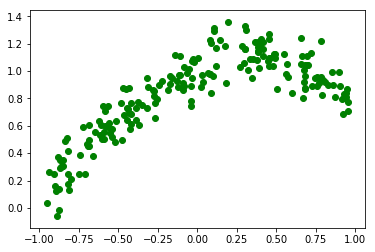

In [2]:
np.random.seed(3)
# 1 + 0.5 * x - 0.5 x^2 - 0.2 x^3 - 0.1 x^4
coeffs = [1, 0.5, -0.5, -0.2, -0.1]
x, y = polynomial_data(coeffs, 200)
plt.scatter(x, y, color='green')

0.7256854071479403


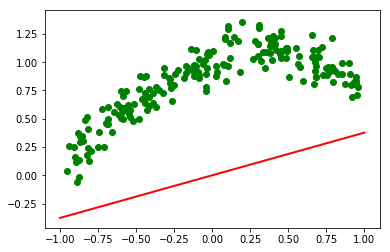

In [3]:
linear_coeff, err = least_squares(x, y)
plt.scatter(x, y, color='green')
plot_linear(linear_coeff)
print(err)

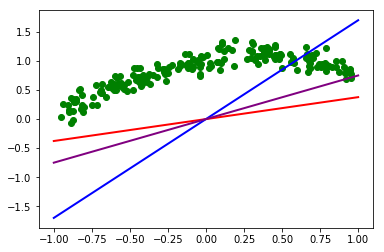

In [4]:
w_fit_right = np.array([[1.7]])
w_closer_right = np.array([[0.75]])
plt.scatter(x, y, color='green')
plot_linear(linear_coeff, color='red')
plot_linear(w_fit_right, color='blue')
plot_linear(w_closer_right, color='purple')

In [5]:
def mse(x, y, w):
    return np.mean((x.dot(w) - y)**2)

In [6]:
print("Regression error", mse(x, y, linear_coeff))
print("Purple line", mse(x, y, w_closer_right))
print("Blue line", mse(x, y, w_fit_right))

Regression error 0.7256854071479403
Purple line 0.7702181887975788
Blue line 1.2863414234807027


# 1. Hyparparameter selection

## Goal: recover a polynomial model from noisy data

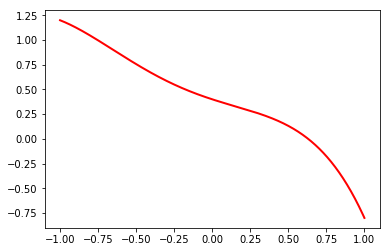

In [7]:
coeffs = [0.4, -0.5, 0.3, -0.5, -0.5]
plot_polynomial(coeffs)

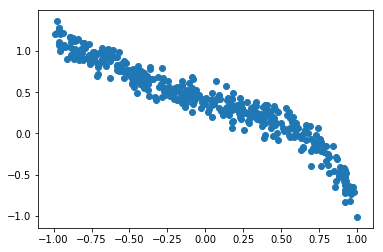

In [8]:
DATASET_SIZE = 400

np.random.seed(0)
x, y = polynomial_data(coeffs, n_data=DATASET_SIZE)
plt.scatter(x, y)

## If we know the degree of the polynomial, can we recover the coeffs?

In [9]:
features_4 = polynomial_features(x, 4)
w_4, err = least_squares(features_4, y)
print(w_4.flatten())
print(coeffs)

[ 0.398 -0.483  0.271 -0.509 -0.505]
[0.4, -0.5, 0.3, -0.5, -0.5]


## What if we don't know the degree?

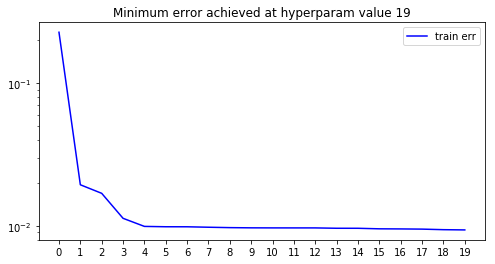

In [10]:
errs = []
ws = []
for i in range(20):
    w, err = least_squares(polynomial_features(x, i), y)
    errs.append(err)
    ws.append(w)

plt.figure(figsize=(8, 4))
plot_errors(errs)

## Let's evaluate the learned model against the true underlying model

#### How does the degree 4 polynomial we found compare?

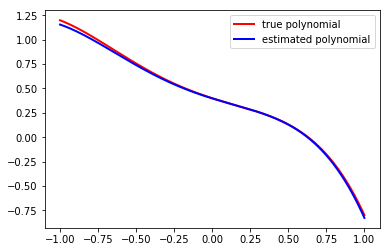

In [11]:
plot_polynomial(coeffs, color='red', label='true polynomial')
plot_polynomial(w_4, color='blue', label='estimated polynomial')
plt.legend()

#### What about the degree 19?

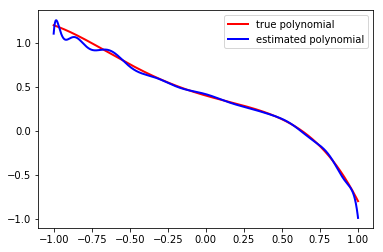

In [12]:
plot_polynomial(coeffs, color='red', label='true polynomial')
plot_polynomial(ws[-1], color='blue', label='estimated polynomial')
plt.legend()

#### Let's see if we can make this intuition more quantitative

In [13]:
def validation_error(eval_x, eval_y, w):
    pred_y = polynomial(eval_x, w).flatten()
    
    err = np.mean((eval_y.flatten() - pred_y.flatten()) ** 2)    

    return err

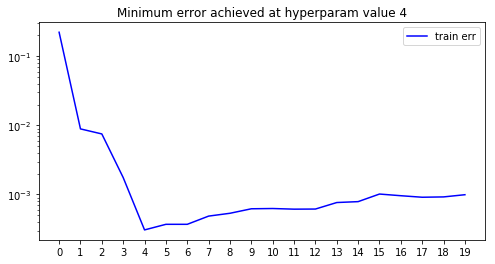

In [14]:
errs = []
eval_x = np.linspace(-1, 1, 1000)
eval_y = polynomial(eval_x, coeffs).flatten()
for w in ws:
    errs.append(validation_error(eval_x, eval_y, w))

plt.figure(figsize=(8, 4))
plot_errors(errs)

## Now let's try 'infinite' noisy data

In [15]:
eval_x, eval_y = polynomial_data(coeffs, n_data=10000)

#### Degree 4

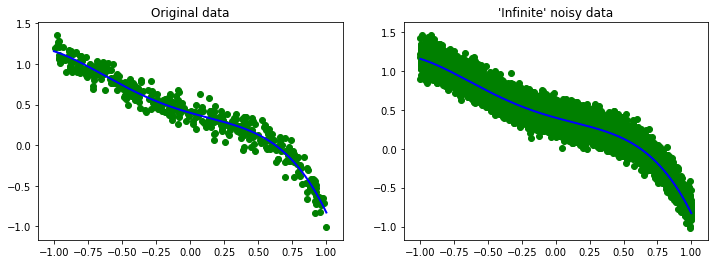

In [16]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plot_polynomial(w_4, color='blue')
plt.scatter(x, y, color='green')
plt.title("Original data")
plt.subplot(122)
plot_polynomial(w_4, color='blue')
plt.scatter(eval_x, eval_y, color='green')
plt.title("'Infinite' noisy data")
plt.show()

#### Degree 19

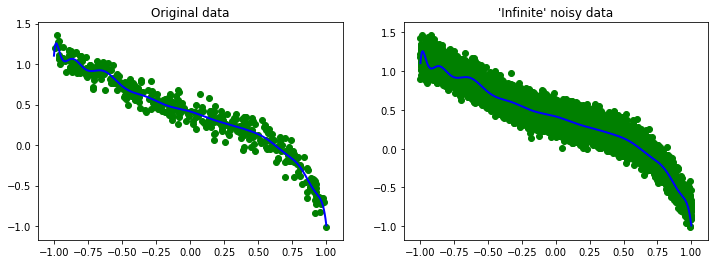

In [17]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plot_polynomial(ws[-1], color='blue')
plt.scatter(x, y, color='green')
plt.title("Original data")
plt.subplot(122)
plot_polynomial(ws[-1], color='blue')
plt.scatter(eval_x, eval_y, color='green')
plt.title("'Infinite' noisy data")
plt.show()

#### Quantitative

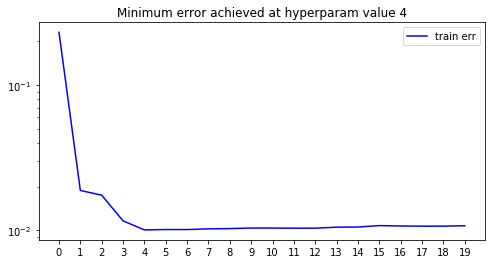

In [18]:
errs = []
for w in ws:
    errs.append(validation_error(eval_x, eval_y, w))

plt.figure(figsize=(8, 4))
plot_errors(errs)

## A realistic approach: validation sets

In [19]:
N_TRAIN = DATASET_SIZE // 2
x_train, y_train = x[:N_TRAIN], y[:N_TRAIN]
x_val, y_val = x[N_TRAIN:], y[N_TRAIN:]

In [20]:
errs_train = []
ws_train = []
errs_val = []
for i in range(20):
    w, err = least_squares(polynomial_features(x_train, i), y_train)
    errs_train.append(err)
    errs_val.append(validation_error(x_val, y_val, w))
    ws_train.append(w)

#### Degree 4

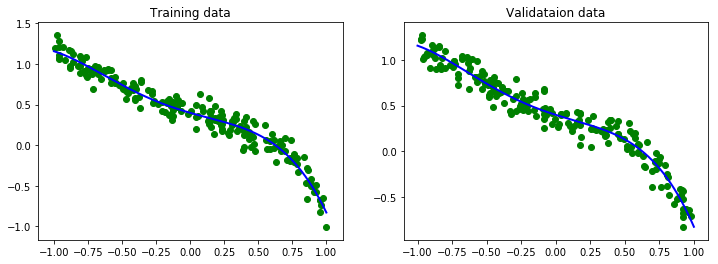

In [21]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plot_polynomial(ws[4], color='blue')
plt.scatter(x_train, y_train, color='green')
plt.title("Training data")
plt.subplot(122)
plot_polynomial(ws[4], color='blue')
plt.scatter(x_val, y_val, color='green')
plt.title("Validataion data")
plt.show()

#### Degree 19

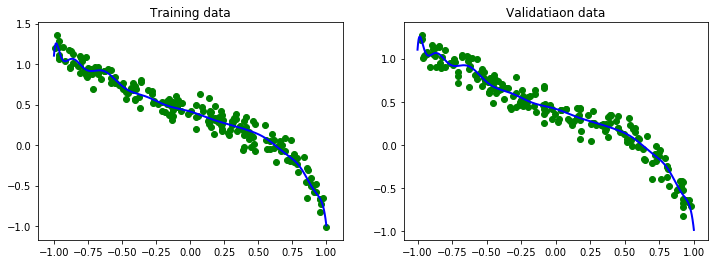

In [22]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plot_polynomial(ws[-1], color='blue')
plt.scatter(x_train, y_train, color='green')
plt.title("Training data")
plt.subplot(122)
plot_polynomial(ws[-1], color='blue')
plt.scatter(x_val, y_val, color='green')
plt.title("Validatiaon data")
plt.show()

#### Quantitative

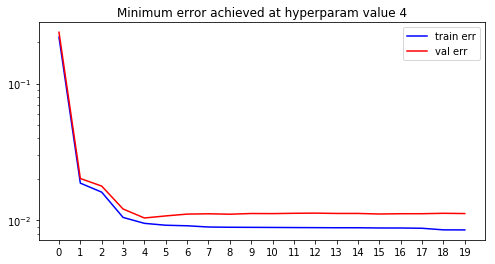

In [23]:
plt.figure(figsize=(8, 4))
plot_errors(errs_train, label="train err", color='b')
plot_errors(errs_val, label="val err", color="r")

# 2. Regularization

## Let's try to recover the same polynomial, but from a different range

Coefficients:  [0.4, -0.5, 0.3, -0.5, -0.5]


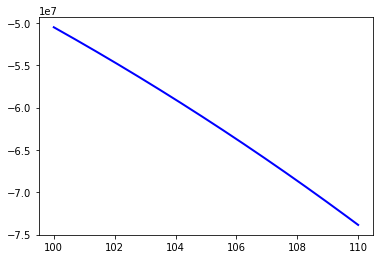

In [24]:
print("Coefficients: ", coeffs)
x_range = [100, 110]
plot_polynomial(coeffs, x_range=x_range, color='b')

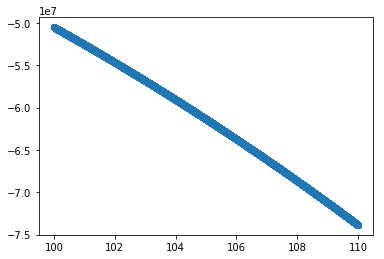

In [25]:
np.random.seed(0)
x, y = polynomial_data(coeffs, x_range=x_range, n_data=10000)
plt.scatter(x, y)

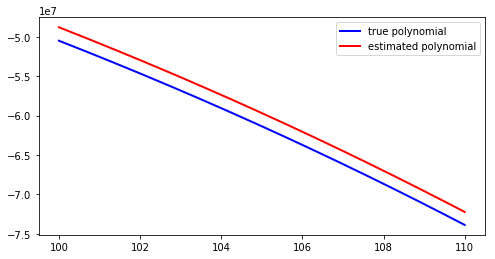

In [26]:
features_4 = polynomial_features(x, 4)
w, err = least_squares(features_4, y)

plt.figure(figsize=(8, 4))
plot_polynomial(coeffs, x_range=x_range, color='b', label='true polynomial')
plot_polynomial(w, x_range=x_range, color='r', label='estimated polynomial')
plt.legend()

In [27]:
print("True coeffs", coeffs)
print("Estimated coeffs", w.flatten())

True coeffs [0.4, -0.5, 0.3, -0.5, -0.5]
Estimated coeffs [ 1.605e+06  1.728e+04 -2.143e+02 -3.061e-01 -4.967e-01]


In [28]:
np.linalg.eig(features_4.T.dot(features_4))[0]

array([1.505e+20, 1.003e+13, 5.575e+05, 6.364e-05, 4.728e-02])

## Ridge regression

In [29]:
def ridge_regression(x, y, l=1.0):
    # TODO: modify linear regression to avoid numerical instability
    xTx = x.T.dot(x)
    w = np.linalg.inv(xTx + l * np.eye(xTx.shape[0])).dot(x.T.dot(y))
    err = np.mean((x.dot(w) - y) ** 2)
    return w, err

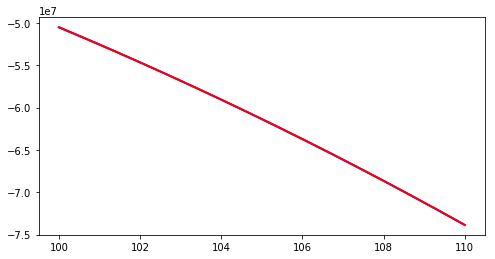

In [30]:
LAMBDA = 50
w, err = ridge_regression(features_4, y, l=LAMBDA)
plt.figure(figsize=(8, 4))
plot_polynomial(coeffs, x_range=x_range, color='b')
plot_polynomial(w, x_range=x_range)

In [31]:
print("True coeffs", coeffs)
print("Estimated coeffs", w.flatten())

True coeffs [0.4, -0.5, 0.3, -0.5, -0.5]
Estimated coeffs [ 0.434 -0.011  0.286 -0.5   -0.5  ]
